In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_area(contours,image4):
    # 获取轮廓点集
    contour = contours[-1]

    # 提取横坐标
    x_coordinates = contour[:, 0, 0]

    # 获取最左和最右坐标
    leftmost_x = np.min(x_coordinates)
    rightmost_x = np.max(x_coordinates)
#     print("leftmost_x,rightmost_x:",leftmost_x,rightmost_x)
    image_crop=image4[:,:rightmost_x]
    # 获取图像的高度和宽度
    height, width = image4.shape[:2]
#     print("height_crop, width_crop:",height, width)


    
    morph_find(image_crop)
    # 将图像转换为HSV颜色空间
    hsv = cv2.cvtColor(image_crop, cv2.COLOR_BGR2HSV)

    # 定义深蓝色范围
    lower_dark_blue = np.array([110, 50, 50])  # 深蓝色下限
    upper_dark_blue = np.array([130, 255, 255])  # 深蓝色上限

    # 创建深蓝色掩码
    dark_blue_mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)

    # 计算非零像素数量
    blue_area = cv2.countNonZero(dark_blue_mask)

    return blue_area

In [8]:
def capture_airfoil(file_path):
    image = cv2.imread(file_path)
    # 获取图像的高度和宽度
    height, width = image.shape[:2]
    print("height, width:",height, width)

    # 计算要保留的像素范围
    top_h=int(0.15*height)
    bottom_h=int(0.85*height)

    top_w=int(0.15*width)
    bottom_w=int(0.85*width)

    # 截取图像的上部分
    image = image[top_h:bottom_h, top_w:bottom_w]
    height, width = image.shape[:2]

    # 将图像转换为灰度图像
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 对灰度图像进行阈值处理
    _, threshold = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
    
    # 创建一个新的图形
    plt.figure()

    # 将图像显示在图形中
    plt.imshow(threshold)

    # 显示图形
    plt.show()
    
    # 连通组件分析
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(threshold)

    # 获取每个区域掩膜的单独最大和最小纵坐标
    for i in range(1, num_labels):  # 跳过背景区域（标签0）
        min_y = stats[i, 1]
        max_y = stats[i, 1] + stats[i, 3]
        if(min_y>0 and max_y<height):
            region_mask = np.uint8(labels == i) * 255  # 创建区域掩膜
            region_image = cv2.bitwise_and(image, image, mask=region_mask)  # 通过按位与操作提取区域图像    
            # 创建一个新的图形
            plt.figure()

            # 将图像显示在图形中
            plt.imshow(region_image)

            # 显示图形
            plt.show()


    # 使用Canny边缘检测
    edges = cv2.Canny(region_image, 100, 200)

    # 寻找最外侧的轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return calculate_area(contours,image)

In [ ]:
def draw_contour(image,path,x0,y0):
    filename = path.split("/")[-1].split(".")[0]
    case_number = filename.split("-")[0]
    
    a = [[x1, y1], [x2, y2], ..., [xn, yn]]
    [x0, y0] = [10, 20]  # 要添加的坐标

    new_a = [[x + x0, y + y0] for x, y in a]
    
    import numpy as np

    # line_coordinates 是一个包含现有坐标的列表
    line_coordinates = [[100, 200], [300, 400]]

    # x 是要添加的新坐标
    x = 500

    # canvas 是现有图像
    canvas = np.zeros((800, 800, 3), dtype=np.uint8)

    # 将新坐标与 line_coordinates 进行拼接
    new_coordinates = np.concatenate((line_coordinates, [[x, canvas.shape[0], 0]]), axis=0)

    print("更新后的坐标：", new_coordinates)
    
    # 读取画布
    canvas = cv2.imread("canvas.jpg")

    # 转换为HSV颜色空间
    hsv = cv2.cvtColor(canvas, cv2.COLOR_BGR2HSV)

    # 定义深蓝色的HSV范围
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([130, 255, 255])

    # 根据阈值提取深蓝色区域
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # 进行膨胀和腐蚀操作，消除噪声
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # 提供线的坐标数据
    line_coordinates = [[100, 200], [300, 400]]  # 示例坐标数据

    # 创建一个与画布相同大小的掩膜图像
    line_mask = np.zeros_like(mask)

    # 将线的坐标数据绘制在掩膜图像上
    cv2.fillPoly(line_mask, [np.array(line_coordinates)], 255)

    # 与深蓝色区域的掩膜进行按位与操作，获取线上方的深蓝色区域
    blue_area_above_line = cv2.bitwise_and(mask, line_mask)
    return image

height, width: 879 1278


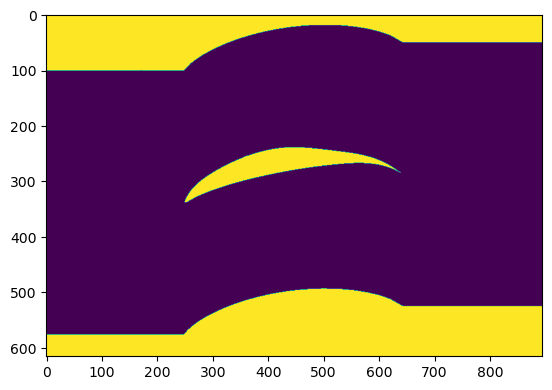

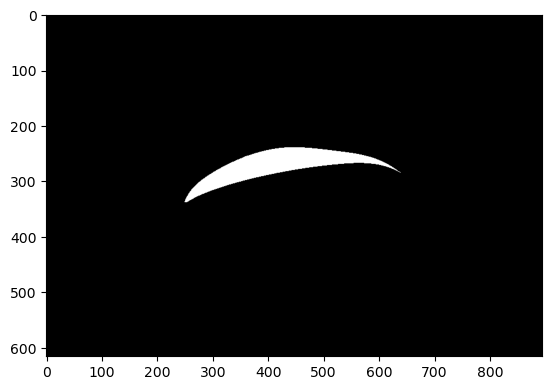

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'pointPolygonTest'
> Overload resolution failed:
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type


<Figure size 640x480 with 0 Axes>

In [9]:
image4 = cv2.imread("/kaggle/input/flowfieldpic/Pic/case1-100.png")

capture_airfoil("/kaggle/input/flowfieldpic/Pic/case102-240.png")

In [ ]:
import os
import glob

# 指定文件夹路径
pic_path = glob.glob("/kaggle/input/flowfieldpic/Pic/*")

df = pd.DataFrame(columns=["图片名", '失速面积','失速开始位置'])

# 遍历文件夹中的所有文件
for file_path in pic_path:
    area=capture_airfoil(file_path)
    # 迭代添加行数据
    data = {'图片名': file_name,
            '失速面积': area,
           '失速开始位置':start_coor}
    df.loc[len(df)] = data
    # 保存到Excel文件
    df.to_excel('分类结果.xlsx', index=False)
    